# LIBE Correction


In [ ]:
import pandas as pd
import os 
! ls ../../../data/splits_1205/libe_qtaim_1205_labelled.pkl
folder_loc = "../../../data/splits_1205/"
loc_libe = "../../../data/splits_1205/libe_qtaim_1205_labelled.pkl"
libe_full = pd.read_pickle(loc_libe)
# get all datasets with libe in the name 
datasets_update = [x for x in os.listdir(folder_loc) if "libe" in x]

In [2]:
datasets_update


['train_libe_qtaim_1205_labelled_charge_1.pkl',
 'train_libe_qtaim_1205_labelled_10000.pkl',
 'libe_qtaim_1205_labelled.pkl',
 'train_libe_qtaim_1205_labelled.pkl',
 'train_libe_1205_small.pkl',
 'train_libe_1205_large.pkl',
 'train_libe_qtaim_1205_labelled_spin_2.pkl',
 'test_libe_qtaim_1205_labelled_spin_3.pkl',
 'train_libe_qtaim_1205_labelled_100.pkl',
 'train_libe_qtaim_1205_labelled_spin_1.pkl',
 'test_libe_qtaim_1205_labelled.pkl',
 'test_libe_qtaim_1205_labelled_charge_neg_1.pkl',
 'libe_qtaim_1205_labelled_corrected.pkl',
 'test_libe_qtaim_1205_labelled_charge_1_neg_1.pkl',
 'test_libe_1205_small.pkl',
 'test_libe_qtaim_1205_labelled_charge_1.pkl',
 'test_libe_qtaim_1205_labelled_charge_0.pkl',
 'train_libe_qtaim_1205_labelled_spin_3.pkl',
 'test_libe_qtaim_1205_labelled_spin_1.pkl',
 'train_libe_qtaim_1205_labelled_1000.pkl',
 'test_libe_1205_large.pkl',
 'test_libe_qtaim_1205_labelled_spin_2.pkl',
 'train_libe_qtaim_1205_labelled_10.pkl',
 'train_libe_qtaim_1205_labelled_cha

In [1]:
def get_elem_list(molecule):
    return [site.specie for site in molecule.sites]


elem_to_int = {
    "H": 1,
    "He": 2,
    "Li": 3,
    "Be": 4,
    "B": 5,
    "C": 6,
    "N": 7,
    "O": 8,
    "F": 9,
    "S": 16,
    "P": 15,
    "Ne": 10,
    "Mg": 12,
}


In [11]:
from tqdm import tqdm, trange
import numpy as np
from copy import deepcopy


def get_elem_list(molecule):
    return [site.specie for site in molecule.sites]


# function to find what elements are present in the dataset
def elem_present(df):
    elem_list = []
    print("Calculating elements present in dataset")
    for i, row in tqdm(df.iterrows()):
        molecule = row.molecule_graph.molecule
        for elem in get_elem_list(molecule):  # todo
            elem = str(elem)
            # for elem in structure.atomic_numbers:  # todo
            if int(elem_to_int[elem]) not in elem_list:
                elem_list.append(int(elem_to_int[elem]))
    elem_list.sort()
    return elem_list


# function to create the coefficient matrix
# row for each structure, column for each element
# each entry tells the number of times that element is in that structure
def coeff_matrix_func(elem_list, df):
    num_structures = df.shape[0]
    num_elems = len(elem_list)
    matrix = np.zeros((num_structures, num_elems))
    # print("Constructing coefficient matrix")
    # print("matrix shape", matrix.shape)
    # print("number of structures", num_structures)
    for i in trange(num_structures):
        row = df.iloc[i]
        molecule = row.molecule_graph.molecule
        elems = get_elem_list(molecule)
        elems = [elem_to_int[str(elem)] for elem in elems]
        for elem in elems:
            for j in range(len(elem_list)):
                if int(elem) == elem_list[j]:
                    try:
                        matrix[i][j] += 1
                    except:
                        print(i, j)
                        # throw error if the element is not in the list
                        raise ValueError("Element not in list")
    return matrix


# function to solve for the target values attributable to any given element
def target_references(coeff_matrix, df):
    sol_matrix = np.zeros(len(df))
    for i in range(len(df)):
        # sol_matrix[i] = dataset[i].y_relaxed  # todo
        sol_matrix[i] = df.iloc[i].shifted_rrho_ev_free_energy
    sol_matrix = sol_matrix.T
    vars = np.linalg.solve(coeff_matrix.T @ coeff_matrix, coeff_matrix.T @ sol_matrix)
    return vars


# function to subtract off target values attributable to each individual element
def target_correction(coeff_matrix, target_references, df):
    df_ret = deepcopy(df)
    print("Correcting targets")
    debug_list = []
    # for i in trange(len(dataset)):
    for i in range(len(df_ret)):
        data = df_ret.iloc[i]
        reference_target = coeff_matrix[i, :] @ target_references
        corrected_target = data.shifted_rrho_ev_free_energy - reference_target  # todo
        # overwrite the target values with the corrected values
        debug_list.append(corrected_target)
        # df_ret.iloc[i].shifted_rrho_ev_free_energy = corrected_target
        # new_dataset.append(data)
    df_ret["corrected_E"] = debug_list
    return df_ret, debug_list
    # return debug_list


In [28]:
elems_present_libe = elem_present(libe_full)
matrix = coeff_matrix_func(elems_present_libe, libe_full)
target_refs_libe = target_references(matrix, libe_full)
df_ret, debug_list = target_correction(matrix, target_refs_libe, libe_full)
# overwrite pickle with new one
df_ret.to_pickle("../../../data/splits_1205/libe_qtaim_1205_labelled_corrected.pkl")


Calculating elements present in dataset


17157it [00:00, 49096.23it/s]
100%|██████████| 17157/17157 [00:00<00:00, 21801.28it/s]


Correcting targets


In [21]:
elems_present_libe


[1, 3, 6, 7, 8, 9, 15, 16]

In [22]:
target_refs_libe


array([   -16.77537562,   -206.45292515,  -1034.69861041,  -1488.80081496,
        -2048.19270236,  -2717.83725543,  -9286.36995521, -10831.57826394])

In [30]:
failed_datasets = []
# iterate through all datasets and correct them
for dataset in datasets_update:
    try:
        dataset_loc = folder_loc + dataset
        dataset_df = pd.read_pickle(dataset_loc)
        print(dataset, dataset_df.shape)
        elems_present = elem_present(dataset_df)
        matrix = coeff_matrix_func(elems_present, dataset_df)
        # target_refs = target_references(matrix, dataset_df)
        df_ret, debug_list = target_correction(matrix, target_refs_libe, dataset_df)
        # overwrite pickle with new one
        dataset_loc_new = dataset_loc.replace(".pkl", "_corrected.pkl")
        df_ret.to_pickle(dataset_loc_new)
    except:
        failed_datasets.append(dataset)


train_libe_qtaim_1205_labelled_charge_1.pkl (4555, 55)
Calculating elements present in dataset


4555it [00:00, 40345.01it/s]
100%|██████████| 4555/4555 [00:00<00:00, 24422.30it/s]


Correcting targets
train_libe_qtaim_1205_labelled_10000.pkl (10000, 55)
Calculating elements present in dataset


10000it [00:00, 41871.19it/s]
100%|██████████| 10000/10000 [00:00<00:00, 24569.75it/s]


Correcting targets
libe_qtaim_1205_labelled.pkl (17157, 55)
Calculating elements present in dataset


17157it [00:00, 43556.85it/s]
100%|██████████| 17157/17157 [00:00<00:00, 19731.14it/s]


Correcting targets
train_libe_qtaim_1205_labelled.pkl (15441, 55)
Calculating elements present in dataset


15441it [00:00, 40093.63it/s]
100%|██████████| 15441/15441 [00:00<00:00, 23911.96it/s]


Correcting targets
train_libe_1205_small.pkl (1969, 56)
Calculating elements present in dataset


1969it [00:00, 52580.35it/s]
100%|██████████| 1969/1969 [00:00<00:00, 30045.09it/s]

Correcting targets


train_libe_1205_large.pkl (13472, 56)
Calculating elements present in dataset


13472it [00:00, 38078.59it/s]
100%|██████████| 13472/13472 [00:00<00:00, 22903.25it/s]


Correcting targets
train_libe_qtaim_1205_labelled_spin_2.pkl (6872, 55)
Calculating elements present in dataset


6872it [00:00, 38988.86it/s]
100%|██████████| 6872/6872 [00:00<00:00, 23211.02it/s]


Correcting targets
test_libe_qtaim_1205_labelled_spin_3.pkl (250, 55)
Calculating elements present in dataset


250it [00:00, 46680.14it/s]
100%|██████████| 250/250 [00:00<00:00, 34153.35it/s]


Correcting targets
train_libe_qtaim_1205_labelled_100.pkl (100, 55)
Calculating elements present in dataset


100it [00:00, 47962.31it/s]
100%|██████████| 100/100 [00:00<00:00, 30595.26it/s]

Correcting targets


train_libe_qtaim_1205_labelled_spin_1.pkl (6391, 55)
Calculating elements present in dataset


6391it [00:00, 38214.51it/s]
100%|██████████| 6391/6391 [00:00<00:00, 23187.10it/s]


Correcting targets
test_libe_qtaim_1205_labelled.pkl (1716, 55)
Calculating elements present in dataset


1716it [00:00, 39388.09it/s]
100%|██████████| 1716/1716 [00:00<00:00, 23933.02it/s]

Correcting targets


test_libe_qtaim_1205_labelled_charge_neg_1.pkl (604, 55)
Calculating elements present in dataset


604it [00:00, 41326.56it/s]
100%|██████████| 604/604 [00:00<00:00, 27906.28it/s]

Correcting targets


libe_qtaim_1205_labelled_corrected.pkl (17157, 56)
Calculating elements present in dataset


17157it [00:00, 41020.94it/s]
100%|██████████| 17157/17157 [00:00<00:00, 24971.47it/s]


Correcting targets
test_libe_qtaim_1205_labelled_charge_1_neg_1.pkl (1110, 55)
Calculating elements present in dataset


1110it [00:00, 37414.53it/s]
100%|██████████| 1110/1110 [00:00<00:00, 23532.18it/s]

Correcting targets


test_libe_1205_small.pkl (215, 56)
Calculating elements present in dataset


215it [00:00, 56516.38it/s]
100%|██████████| 215/215 [00:00<00:00, 35572.99it/s]


Correcting targets
test_libe_qtaim_1205_labelled_charge_1.pkl (506, 55)
Calculating elements present in dataset


506it [00:00, 45232.69it/s]
100%|██████████| 506/506 [00:00<00:00, 27783.39it/s]

Correcting targets


test_libe_qtaim_1205_labelled_charge_0.pkl (606, 55)
Calculating elements present in dataset


606it [00:00, 42296.91it/s]
100%|██████████| 606/606 [00:00<00:00, 25550.60it/s]


Correcting targets
train_libe_qtaim_1205_labelled_spin_3.pkl (2178, 55)
Calculating elements present in dataset


2178it [00:00, 45917.50it/s]
100%|██████████| 2178/2178 [00:00<00:00, 27879.34it/s]

Correcting targets


test_libe_qtaim_1205_labelled_spin_1.pkl (742, 55)
Calculating elements present in dataset


742it [00:00, 40148.27it/s]
100%|██████████| 742/742 [00:00<00:00, 27993.72it/s]

Correcting targets


train_libe_qtaim_1205_labelled_1000.pkl (1000, 55)
Calculating elements present in dataset


1000it [00:00, 39642.96it/s]
100%|██████████| 1000/1000 [00:00<00:00, 26227.84it/s]

Correcting targets


test_libe_1205_large.pkl (1501, 56)
Calculating elements present in dataset


1501it [00:00, 39319.80it/s]
100%|██████████| 1501/1501 [00:00<00:00, 23351.47it/s]

Correcting targets


test_libe_qtaim_1205_labelled_spin_2.pkl (724, 55)
Calculating elements present in dataset


724it [00:00, 41862.09it/s]
100%|██████████| 724/724 [00:00<00:00, 25599.39it/s]


Correcting targets
train_libe_qtaim_1205_labelled_10.pkl (10, 55)
Calculating elements present in dataset


10it [00:00, 22671.91it/s]
100%|██████████| 10/10 [00:00<00:00, 23523.86it/s]

Correcting targets


train_libe_qtaim_1205_labelled_charge_neg_1.pkl (5633, 55)
Calculating elements present in dataset


5633it [00:00, 39100.56it/s]
100%|██████████| 5633/5633 [00:00<00:00, 23454.31it/s]


Correcting targets
train_libe_qtaim_1205_labelled_charge_0.pkl (5253, 55)
Calculating elements present in dataset


5253it [00:00, 42091.84it/s]
100%|██████████| 5253/5253 [00:00<00:00, 24397.59it/s]


Correcting targets


In [31]:
failed_datasets


['train_libe_qtaim_1205_labelled_10.pkl']

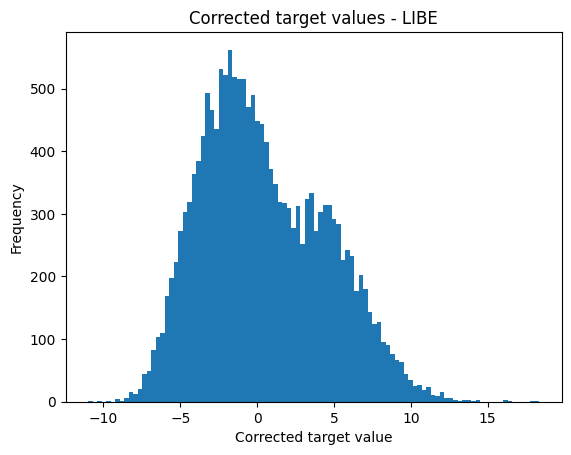

<Figure size 640x480 with 0 Axes>

In [88]:
# plot histogram of corrected target values
import matplotlib.pyplot as plt

plt.hist(debug_list, bins=100)
plt.title("Corrected target values - LIBE")
plt.xlabel("Corrected target value")
plt.ylabel("Frequency")
# plt.show()
# save figu
plt.savefig("corrected_target_hist_libe.png")


In [1]:
base_dict = {
    "atom": [],
    "bond": [],
    "global": ["corrected_E", "charge", "spin"],
}
from qtaim_embed.core.dataset import HeteroGraphGraphLabelDataset
from qtaim_embed.data.dataloader import DataLoaderMoleculeGraphTask

dataset_test_base = HeteroGraphGraphLabelDataset(
    file="../../../data/splits_1205/test_libe_qtaim_1205_labelled_corrected.pkl",
    allowed_ring_size=[3, 4, 5, 6, 7],
    allowed_charges=[-1, 0, 1],
    allowed_spins=[1, 2, 3],
    self_loop=True,
    extra_keys=base_dict,
    target_list=["corrected_E"],
    extra_dataset_info={},
    debug=False,
    log_scale_features=True,
    log_scale_targets=False,
    standard_scale_features=True,
    standard_scale_targets=True,
)

dataloader_train = DataLoaderMoleculeGraphTask(
    dataset_test_base, batch_size=256, shuffle=True, num_workers=0
)
import torch
from sklearn.metrics import r2_score


def manual_statistics(model, batch_graph, batched_labels, scaler_list):
    preds = model.forward(batch_graph, batch_graph.ndata["feat"])

    preds_unscaled = deepcopy(preds.detach())
    labels_unscaled = deepcopy(batched_labels)
    # print("preds unscaled", preds_unscaled)  # * this looks good
    # print("labels unscaled", labels_unscaled)  # * this looks good
    for scaler in scaler_list:
        labels_unscaled = scaler.inverse_feats(labels_unscaled)
        preds_unscaled = scaler.inverse_feats({"global": preds_unscaled})

    preds_unscaled = preds_unscaled["global"].view(-1, model.hparams.ntasks)
    labels_unscaled = labels_unscaled["global"].view(-1, model.hparams.ntasks)
    # manually compute mae and r2
    mae = torch.mean(torch.abs(preds_unscaled - labels_unscaled))
    r2 = r2_score(labels_unscaled, preds_unscaled)
    return mae, r2


... > creating MoleculeWrapper objects


100%|██████████| 1716/1716 [00:00<00:00, 20903.24it/s]


... > bond_feats_error_count:  0
... > atom_feats_error_count:  0
element set {'S', 'O', 'C', 'P', 'H', 'F', 'Li', 'N'}
selected atomic keys []
selected bond keys []
selected global keys ['corrected_E', 'charge', 'spin']
... > Building graphs and featurizing


100%|██████████| 1716/1716 [00:02<00:00, 596.83it/s]


included in labels
{'global': ['corrected_E']}
included in graph features
{'atom': ['total_degree', 'total_H', 'is_in_ring', 'ring_size_3', 'ring_size_4', 'ring_size_5', 'ring_size_6', 'ring_size_7', 'chemical_symbol_S', 'chemical_symbol_O', 'chemical_symbol_C', 'chemical_symbol_P', 'chemical_symbol_H', 'chemical_symbol_F', 'chemical_symbol_Li', 'chemical_symbol_N'], 'bond': ['metal bond', 'ring inclusion', 'ring size_3', 'ring size_4', 'ring size_5', 'ring size_6', 'ring size_7'], 'global': ['num atoms', 'num bonds', 'molecule weight', 'charge one hot', 'charge one hot', 'charge one hot', 'spin one hot', 'spin one hot', 'spin one hot']}
original loader node types: dict_keys(['atom', 'bond', 'global'])
original loader label types: dict_keys([])
include names:  dict_keys(['global'])
... > parsing labels and features in graphs


100%|██████████| 1716/1716 [00:00<00:00, 34316.11it/s]


original loader node types: dict_keys(['atom', 'bond', 'global'])
original loader label types: dict_keys(['global'])
... > Log scaling features
... > Log scaling features complete
... > Scaling features
mean [0.82051049 0.12242161 0.07909777 0.00656382 0.05048244 0.01205826
 0.00859197 0.00140127 0.00413005 0.16778314 0.20550669 0.01191076
 0.21188614 0.04406612 0.0463524  0.00151189]
std [0.5301781  0.31105153 0.22038588 0.06713131 0.1801202  0.09062421
 0.07669211 0.0311339  0.05334485 0.29689599 0.31656498 0.09007798
 0.3193314  0.16912269 0.17314875 0.03233694]
mean [0.         0.09420027 0.00786088 0.05984692 0.01498344 0.01068385
 0.00182407]
std [0.         0.23753096 0.07339587 0.19468197 0.10080292 0.08538931
 0.03551088]
Standard deviation for feature 0 is 0.0, smaller than 0.001. You may want to exclude this feature.
mean [2.41164055 2.24761734 4.63867565 0.24397488 0.24478275 0.20438955
 0.29971749 0.29244671 0.10098298]
std [0.37903647 0.42249919 0.41820949 0.33103891 0.33

In [2]:
non_qtaim_model_dict = {
    "atom_feature_size": 16,
    "bond_feature_size": 7,
    "global_feature_size": 9,
    "conv_fn": "GraphConvDropoutBatch",
    "target_dict": {"global": ["corrected_E"]},
    "dropout": 0,
    "batch_norm_tf": True,
    "activation": "ReLU",
    "bias": True,
    "norm": "both",
    "aggregate": "sum",
    "n_conv_layers": 3,
    "lr": 0.00757866661159144,
    "weight_decay": 1e-05,
    "lr_plateau_patience": 50,
    "lr_scale_factor": 0.75,
    "scheduler_name": "reduce_on_plateau",
    "loss_fn": "mse",
    "resid_n_graph_convs": 3,
    "embedding_size": 16,
    "fc_layer_size": [256, 128],
    "fc_dropout": 0,
    "fc_batch_norm": False,
    "n_fc_layers": 2,
    "global_pooling_fn": "Set2SetThenCat",
    "ntypes_pool": ["atom", "bond", "global"],
    "ntypes_pool_direct_cat": ["global"],
    "lstm_iters": 3,
    "lstm_layers": 2,
    "num_heads": 2,
    "feat_drop": 0,
    "attn_drop": 0,
    "residual": False,
    "hidden_size": 16,
    "ntasks": 1,
    "num_heads_gat": 2,
    "dropout_feat_gat": 0,
    "dropout_attn_gat": 0,
    "hidden_size_gat": 16,
    "residual_gat": False,
    "batch_norm": True,
    "classifier": False,
    "shape_fc": "cone",
    "fc_hidden_size_1": 256,
    "fc_num_layers": 2,
    "restore": False,
    "pooling_ntypes": ["atom", "bond", "global"],
    "pooling_ntypes_direct": ["global"],
}


In [3]:
from qtaim_embed.models.utils import load_graph_level_model_from_config

model_temp = load_graph_level_model_from_config(non_qtaim_model_dict)


:::REGRESSION MODEL:::
readout in size 80
... > number of tasks: 1


In [8]:
import pytorch_lightning as pl

trainer = pl.Trainer(
    max_epochs=200,
    accelerator="gpu",
    gradient_clip_val=2.0,
    devices=1,
    accumulate_grad_batches=1,
    enable_progress_bar=True,
    enable_checkpointing=True,
    strategy="auto",
    # default_root_dir=model_save_string,
    default_root_dir="./test/",
    precision="bf16-mixed",
)

trainer.fit(model_temp, dataloader_train)


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/santiagovargas/anaconda3/envs/qtaim_embed/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:71: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type               | Params
--------------------------------------------------------
0  | activation      | ReLU               | 0     
1  | embedding       | UnifySize          | 512   
2  | conv_layers     | ModuleList         | 8.2 K 
3  | readout         | Set2SetThenCat     | 10.8 K
4  | loss            | MeanSquaredError   | 0     
5  | fc_layers       | ModuleList         | 53.8 K
6  | train_r2        | MultioutputWrapper | 0     
7  | train_torch_l1  | MultioutputWra

Training: 0it [00:00, ?it/s]

Epoch 00052: reducing learning rate of group 0 to 5.6840e-03.
Epoch 00103: reducing learning rate of group 0 to 4.2630e-03.
Epoch 00154: reducing learning rate of group 0 to 3.1972e-03.


`Trainer.fit` stopped: `max_epochs=200` reached.


In [23]:
scaler_list = dataset_test_base.label_scalers
batch_graph, batch_label = next(iter(dataloader_train))
mean_mae, mean_mse, preds_unscaled, labels_unscaled = model_temp.evaluate_manually(
    batch_graph, batch_label, scaler_list, per_atom=True
)
print("Mean MAE(meV/Atom)", 1000 * mean_mae.detach().cpu().numpy())
print("Mean MSE(meV/Atom)", 1000 * mean_mse.detach().cpu().numpy())

(
    r2_val,
    mae_val,
    mse_val,
    preds_unscaled,
    labels_unscaled,
) = model_temp.evaluate_manually(batch_graph, batch_label, scaler_list, per_atom=False)
print("r2: ", r2_val)


Mean MAE(meV/Atom) 21.938033401966095
Mean MSE(meV/Atom) 8.427459746599197
r2:  tensor([0.9947])


In [42]:
from copy import deepcopy

preds = model_temp.forward(batch_graph, batch_graph.ndata["feat"])

preds_unscaled = deepcopy(preds.detach())
labels_unscaled = deepcopy(batch_label)
# print("preds unscaled", preds_unscaled)  # * this looks good
# print("labels unscaled", labels_unscaled)  # * this looks good
for scaler in scaler_list:
    labels_unscaled = scaler.inverse_feats(labels_unscaled)
    preds_unscaled = scaler.inverse_feats({"global": preds_unscaled})

preds_unscaled = preds_unscaled["global"].view(-1, model_temp.hparams.ntasks)
labels_unscaled = labels_unscaled["global"].view(-1, model_temp.hparams.ntasks)
abs_diff = torch.abs(preds_unscaled - labels_unscaled)
print(abs_diff.shape)
abs_diff = abs_diff.view(-1, model_temp.hparams.ntasks)
print(abs_diff.shape)
n_atoms = batch_graph.batch_num_nodes("atom")
n_mols = batch_graph.batch_size
abs_diff = abs_diff.view(n_mols, -1)
print(abs_diff.shape, n_atoms.shape)
# print(abs_diff.shape)
# mae per atom
mae_per_atom = torch.sum(abs_diff, dim=1) / n_atoms
# print binary mask of where the mae per atom is less than 0.043
ewt_prop = torch.sum(mae_per_atom < 0.043) / len(mae_per_atom)
# mse per atom
mse_per_atom = torch.sum(abs_diff**2, dim=1) / n_atoms
# print(mse_per_atom.shape)
mean_mae = torch.mean(mae_per_atom)
mean_mse = torch.sqrt(torch.mean(mse_per_atom))
# return mean_mae, mean_mse, preds_unscaled, labels_unscaled
print("Mean MAE(meV/Atom)", 1000 * mean_mae.detach().cpu().numpy())
print("Mean RMSE(meV/Atom)", 1000 * mean_mse.detach().cpu().numpy())
print("Mean EWT", ewt_prop.detach().cpu().numpy())


torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1]) torch.Size([256])
Mean MAE(meV/Atom) 21.938033401966095
Mean RMSE(meV/Atom) 91.80119633674622
Mean EWT 0.88671875


# QM9


In [6]:
import pandas as pd
import os 
! ls ../../../data/splits_1205/*qm9*

folder_loc = "../../../data/splits_1205/"
loc_qm9 = "../../../data/splits_1205/qm9_qtaim_1205_labelled.pkl"
qm9_full = pd.read_pickle(loc_qm9)
# get all datasets with libe in the name 
datasets_update = [x for x in os.listdir(folder_loc) if "qm9" in x]

../../../data/splits_1205/qm9_qtaim_1205_labelled.pkl
../../../data/splits_1205/qm9_qtaim_1205.pkl
../../../data/splits_1205/test_qm9_1205_large.pkl
../../../data/splits_1205/test_qm9_1205_small.pkl
../../../data/splits_1205/test_qm9_qtaim_1205_labelled.pkl
../../../data/splits_1205/train_qm9_1205_large.pkl
../../../data/splits_1205/train_qm9_1205_small.pkl
../../../data/splits_1205/train_qm9_qtaim_1205_labelled_100000.pkl
../../../data/splits_1205/train_qm9_qtaim_1205_labelled_10000.pkl
../../../data/splits_1205/train_qm9_qtaim_1205_labelled_1000.pkl
../../../data/splits_1205/train_qm9_qtaim_1205_labelled_100.pkl
../../../data/splits_1205/train_qm9_qtaim_1205_labelled_10.pkl
../../../data/splits_1205/train_qm9_qtaim_1205_labelled.pkl


In [14]:
def get_elem_list(molecule):
    return [site.specie for site in molecule.sites]


elem_to_int = {
    "H": 1,
    "He": 2,
    "Li": 3,
    "Be": 4,
    "B": 5,
    "C": 6,
    "N": 7,
    "O": 8,
    "F": 9,
    "S": 16,
    "P": 15,
    "Ne": 10,
    "Mg": 12,
}


# function to solve for the target values attributable to any given element
def target_references(coeff_matrix, df):
    sol_matrix = np.zeros(len(df))
    for i in range(len(df)):
        # sol_matrix[i] = dataset[i].y_relaxed  # todo
        sol_matrix[i] = df.iloc[i].u0
    sol_matrix = sol_matrix.T
    vars = np.linalg.solve(coeff_matrix.T @ coeff_matrix, coeff_matrix.T @ sol_matrix)
    return vars


# function to subtract off target values attributable to each individual element
def target_correction(coeff_matrix, target_references, df):
    df_ret = deepcopy(df)
    print("Correcting targets")
    debug_list = []
    # for i in trange(len(dataset)):
    for i in range(len(df_ret)):
        data = df_ret.iloc[i]
        reference_target = coeff_matrix[i, :] @ target_references
        corrected_target = data.u0 - reference_target  # todo
        # overwrite the target values with the corrected values
        debug_list.append(corrected_target)
        # df_ret.iloc[i].shifted_rrho_ev_free_energy = corrected_target
        # new_dataset.append(data)
    df_ret["corrected_E"] = debug_list
    return df_ret, debug_list
    # return debug_list


In [15]:
elems_present_qm9 = elem_present(qm9_full)
matrix = coeff_matrix_func(elems_present_qm9, qm9_full)
target_refs_qm9 = target_references(matrix, qm9_full)
df_ret, debug_list = target_correction(matrix, target_refs_qm9, qm9_full)
# overwrite pickle with new one
# df_ret.to_pickle("../../../data/splits_1205/qm9_qtaim_1205_labelled_corrected.pkl")
print(elems_present_qm9)
print(target_refs_qm9)

Calculating elements present in dataset


133848it [00:03, 40405.59it/s]
100%|██████████| 133848/133848 [00:05<00:00, 22768.80it/s]


Correcting targets


[1, 6, 7, 8, 9]
[ -0.60381529 -38.0739702  -54.74928931 -75.2254792  -99.86669125]


In [17]:
df_ret.to_pickle("../../../data/splits_1205/qm9_qtaim_1205_labelled_corrected.pkl")


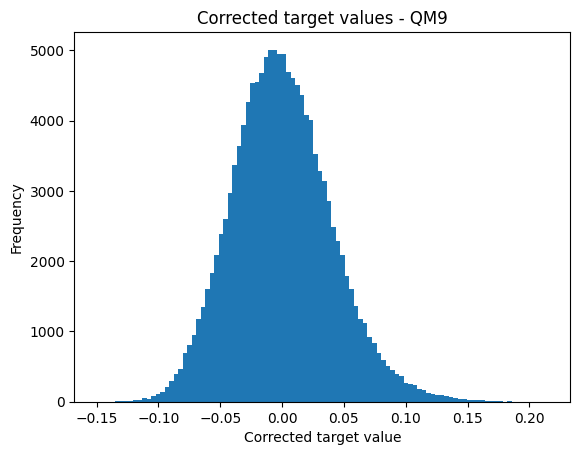

In [18]:
# plot histogram of corrected target values
import matplotlib.pyplot as plt

plt.hist(debug_list, bins=100)
plt.title("Corrected target values - QM9")
plt.xlabel("Corrected target value")
plt.ylabel("Frequency")
# plt.show()
# save figu
plt.savefig("corrected_target_hist_qm9.png")


In [19]:
failed_datasets = []
# iterate through all datasets and correct them
for dataset in datasets_update:
    try:
        dataset_loc = folder_loc + dataset
        dataset_df = pd.read_pickle(dataset_loc)
        print(dataset, dataset_df.shape)
        #elems_present = elem_present(dataset_df)
        matrix = coeff_matrix_func(elems_present_qm9, dataset_df)
        # target_refs = target_references(matrix, dataset_df)
        df_ret, debug_list = target_correction(matrix, target_refs_qm9, dataset_df)
        # overwrite pickle with new one
        dataset_loc_new = dataset_loc.replace(".pkl", "_corrected.pkl")
        df_ret.to_pickle(dataset_loc_new)
    except:
        failed_datasets.append(dataset)


test_qm9_1205_small.pkl (398, 62)


100%|██████████| 398/398 [00:00<00:00, 26377.60it/s]

Correcting targets


qm9_qtaim_1205.pkl (133848, 51)


100%|██████████| 133848/133848 [00:07<00:00, 18874.46it/s]


Correcting targets
train_qm9_qtaim_1205_labelled_100.pkl (100, 61)


100%|██████████| 100/100 [00:00<00:00, 16319.61it/s]

Correcting targets


train_qm9_qtaim_1205_labelled_100000.pkl (100000, 61)


100%|██████████| 100000/100000 [00:04<00:00, 20014.67it/s]


Correcting targets
train_qm9_qtaim_1205_labelled_10.pkl (10, 61)


100%|██████████| 10/10 [00:00<00:00, 11768.53it/s]

Correcting targets


train_qm9_qtaim_1205_labelled_1000.pkl (1000, 61)


100%|██████████| 1000/1000 [00:00<00:00, 19275.91it/s]


Correcting targets
train_qm9_1205_small.pkl (3921, 62)


100%|██████████| 3921/3921 [00:00<00:00, 22617.01it/s]

Correcting targets


test_qm9_qtaim_1205_labelled.pkl (13385, 61)


100%|██████████| 13385/13385 [00:00<00:00, 18428.33it/s]


Correcting targets
train_qm9_qtaim_1205_labelled.pkl (120463, 61)


100%|██████████| 120463/120463 [00:05<00:00, 21058.79it/s]


Correcting targets
train_qm9_1205_large.pkl (116542, 62)


100%|██████████| 116542/116542 [00:05<00:00, 21736.88it/s]


Correcting targets
test_qm9_1205_large.pkl (12987, 62)


100%|██████████| 12987/12987 [00:00<00:00, 19125.99it/s]


Correcting targets
qm9_qtaim_1205_labelled.pkl (133848, 61)


100%|██████████| 133848/133848 [00:06<00:00, 20649.46it/s]


Correcting targets
train_qm9_qtaim_1205_labelled_10000.pkl (10000, 61)


100%|██████████| 10000/10000 [00:00<00:00, 18536.34it/s]


Correcting targets


In [20]:
failed_datasets

['qm9_qtaim_1205.pkl']

# TMQM Correction


In [4]:
import pandas as pd
import os
! ls ~/Downloads/TMCs_qtaim.pkl

folder_loc = "~/Downloads/"
loc_qm9 = "~/Downloads/TMCs_qtaim.pkl"
qm9_full = pd.read_pickle(loc_qm9)

# get all datasets with libe in the name

#datasets_update = [x for x in os.listdir(folder_loc) if "qm9" in x]


/home/santiagovargas/Downloads/TMCs_qtaim.pkl


In [7]:
qm9_full.tzvp_electronic_energy

Index(['molecule', 'molecule_graph', 'bonds', 'charge', 'molecular_mass',
       'xyz_file', 'ids', 'n_atoms', 'n_electrons', 'tzvp_lumo_energy',
       'tzvp_homo_energy', 'tzvp_homo_lumo_gap', 'homo_lumo_gap_delta',
       'tzvp_electronic_energy', 'electronic_energy_delta',
       'tzvp_dispersion_energy', 'dispersion_energy_delta', 'enthalpy_energy',
       'enthalpy_energy_correction', 'gibbs_energy', 'gibbs_energy_correction',
       'zpe_correction', 'heat_capacity', 'entropy', 'tzvp_dipole_moment',
       'dipole_moment_delta', 'polarisability', 'lowest_vibrational_frequency',
       'highest_vibrational_frequency', 'extra_feat_atom_Lagrangian_K',
       'extra_feat_atom_Hamiltonian_K', 'extra_feat_atom_energy_density',
       'extra_feat_atom_lap_e_density', 'extra_feat_atom_e_loc_func',
       'extra_feat_atom_ave_loc_ion_E', 'extra_feat_atom_delta_g_promolecular',
       'extra_feat_atom_delta_g_hirsh', 'extra_feat_atom_esp_nuc',
       'extra_feat_atom_esp_e', 'extra_feat_a

In [82]:
def get_elem_list(molecule):
    return [site.specie for site in molecule.sites]


elem_to_int = {
    "H": 1,
    "He": 2,
    "Li": 3,
    "Be": 4,
    "B": 5,
    "C": 6,
    "N": 7,
    "O": 8,
    "F": 9,
    "S": 16,
    "P": 15,
    "Ne": 10,
    "Mg": 12,
    "Hf": 72,
    "As": 33,
    "Ru": 44, 
    "Cl": 17,
    "Zn": 30,
    "Cu": 29,
    "Pt": 78,
    "Fe": 26,
    "Re": 75,
    "Ti": 22,
    "Pd": 46,
    "Au": 79,
    "Si": 14,
    "Cr": 24,
    "Ni": 28,
    "Co": 27,
    "Hg": 80,
    "Ir": 77,
    "W": 74,
    "Rh": 45,
    "Cd": 48,
    "Mo": 42,
    "Br": 35,
    "I": 53,
    "Se": 34,
    "V": 23,
    "Zr": 40,
    "Ag": 47,
    "Mn": 25,
    "Nb": 41,
    "Sc": 21,
    "Y": 39,
    "Os": 76,
    "Ta": 73,
    "Tc": 43,
    "La": 57
}


# function to solve for the target values attributable to any given element
def target_references(coeff_matrix, df):
    sol_matrix = np.zeros(len(df))
    for i in range(len(df)):
        # sol_matrix[i] = dataset[i].y_relaxed  # todo
        sol_matrix[i] = df.iloc[i].tzvp_electronic_energy # update
    sol_matrix = sol_matrix.T
    vars = np.linalg.solve(coeff_matrix.T @ coeff_matrix, coeff_matrix.T @ sol_matrix)
    return vars


# function to subtract off target values attributable to each individual element
def target_correction(coeff_matrix, target_references, df):
    df_ret = deepcopy(df)
    print("Correcting targets")
    debug_list = []
    # for i in trange(len(dataset)):
    for i in range(len(df_ret)):
        data = df_ret.iloc[i]
        reference_target = coeff_matrix[i, :] @ target_references
        corrected_target = data.tzvp_electronic_energy - reference_target  # update
        # overwrite the target values with the corrected values
        debug_list.append(corrected_target)
        # df_ret.iloc[i].shifted_rrho_ev_free_energy = corrected_target
        # new_dataset.append(data)
    df_ret["corrected_E"] = debug_list
    return df_ret, debug_list
    # return debug_list


In [83]:
elems_present_qm9 = elem_present(qm9_full)
matrix = coeff_matrix_func(elems_present_qm9, qm9_full)
target_refs_qm9 = target_references(matrix, qm9_full)
df_ret, debug_list = target_correction(matrix, target_refs_qm9, qm9_full)

Calculating elements present in dataset


57568it [00:02, 21760.55it/s]
100%|██████████| 57568/57568 [00:08<00:00, 7024.36it/s]


Correcting targets


In [84]:
print(elems_present_qm9)
print(target_refs_qm9)


[1, 5, 6, 7, 8, 9, 14, 15, 16, 17, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 33, 34, 35, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 53, 57, 72, 73, 74, 75, 76, 77, 78, 79, 80]
[-6.01063039e-01 -2.48516751e+01 -3.80776361e+01 -5.47125995e+01
 -7.51869894e+01 -9.97966426e+01 -2.89443529e+02 -3.41270378e+02
 -3.98089551e+02 -4.60107555e+02 -7.60596988e+02 -8.49364765e+02
 -9.43870392e+02 -1.04425352e+03 -1.15075620e+03 -1.26347156e+03
 -1.38248877e+03 -1.50809580e+03 -1.64022931e+03 -1.77916929e+03
 -2.23563332e+03 -2.40130198e+03 -2.57390380e+03 -3.84148663e+01
 -4.71516244e+01 -5.70616705e+01 -6.82606648e+01 -8.08248687e+01
 -9.48935165e+01 -1.10543645e+02 -1.27888822e+02 -1.46880937e+02
 -1.67732457e+02 -2.97781367e+02 -3.16079259e+01 -4.81245941e+01
 -5.71015909e+01 -6.71445701e+01 -7.83523487e+01 -9.06854993e+01
 -1.04376966e+02 -1.19349347e+02 -1.35684545e+02 -1.53421480e+02]


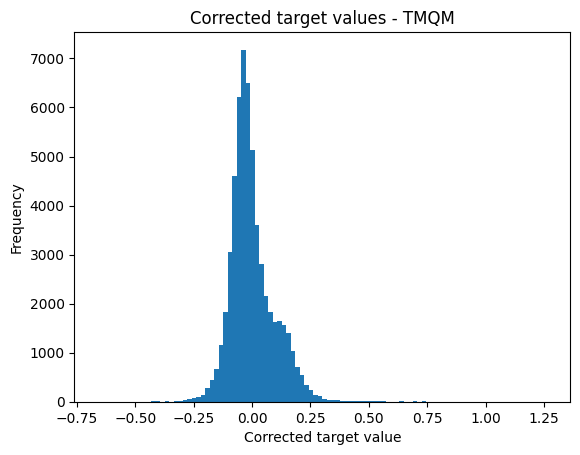

In [85]:
# plot histogram of corrected target values
import matplotlib.pyplot as plt

plt.hist(debug_list, bins=100)
plt.title("Corrected target values - TMQM")
plt.xlabel("Corrected target value")
plt.ylabel("Frequency")
# plt.show()
# save figu
plt.savefig("corrected_target_hist_tmqm.png")


In [87]:
#loc_qm9

loc_qm9_new = loc_qm9.replace(".pkl", "_corrected.pkl")
df_ret.to_pickle(loc_qm9_new)

# RadQM9

In [12]:
import pandas as pd
import os 

def get_elem_list(molecule):
    return [site.specie for site in molecule.sites]


elem_to_int = {
    "H": 1,
    "He": 2,
    "Li": 3,
    "Be": 4,
    "B": 5,
    "C": 6,
    "N": 7,
    "O": 8,
    "F": 9,
    "S": 16,
    "P": 15,
    "Ne": 10,
    "Mg": 12,
}


# function to solve for the target values attributable to any given element
def target_references(coeff_matrix, df):
    sol_matrix = np.zeros(len(df))
    for i in range(len(df)):
        # sol_matrix[i] = dataset[i].y_relaxed  # todo
        sol_matrix[i] = df.iloc[i].energy
    sol_matrix = sol_matrix.T
    vars = np.linalg.solve(coeff_matrix.T @ coeff_matrix, coeff_matrix.T @ sol_matrix)
    return vars


# function to subtract off target values attributable to each individual element
def target_correction(coeff_matrix, target_references, df):
    df_ret = deepcopy(df)
    print("Correcting targets")
    debug_list = []
    # for i in trange(len(dataset)):
    for i in range(len(df_ret)):
        data = df_ret.iloc[i]
        reference_target = coeff_matrix[i, :] @ target_references
        corrected_target = data.energy - reference_target  # todo
        # overwrite the target values with the corrected values
        debug_list.append(corrected_target)
        # df_ret.iloc[i].shifted_rrho_ev_free_energy = corrected_target
        # new_dataset.append(data)
    df_ret["corrected_E"] = debug_list
    return df_ret, debug_list
    # return debug_list


In [13]:
loc_qm9_val = "../../../data/radqm9/radqm_val.json"
loc_qm9_test = "../../../data/radqm9/radqm_test.json"
loc_qm9_train = "../../../data/radqm9/radqm_train.json"


In [ ]:
qm9_full = pd.read_pickle(loc_qm9_train)
elems_present_qm9 = elem_present(qm9_full)
matrix = coeff_matrix_func(elems_present_qm9, qm9_full)
target_refs_qm9 = target_references(matrix, qm9_full)
df_ret, debug_list = target_correction(matrix, target_refs_qm9, qm9_full)
# overwrite pickle with new one
df_ret.to_pickle("../../../data/radqm9/radqm_train_corrected.json")
print(elems_present_qm9)
print(target_refs_qm9)

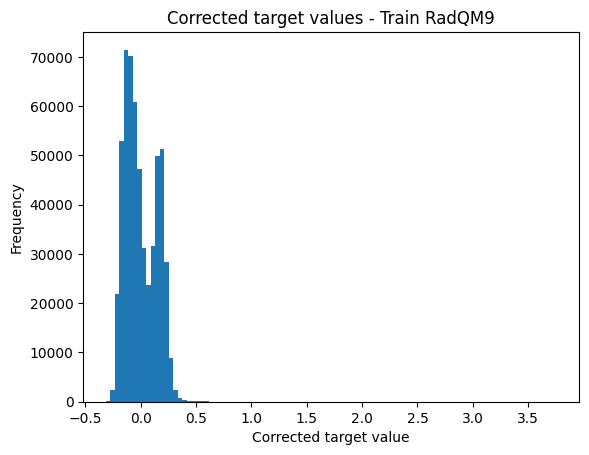

In [4]:
# plot histogram of corrected target values
import matplotlib.pyplot as plt

plt.hist(debug_list, bins=100)
plt.title("Corrected target values - Train RadQM9")
plt.xlabel("Corrected target value")
plt.ylabel("Frequency")
# plt.show()
# save figu
plt.savefig("train_corrected_target_hist_radqm9.png")

In [5]:
qm9_test = pd.read_pickle(loc_qm9_test)
matrix = coeff_matrix_func(elems_present_qm9, qm9_test)
df_ret, debug_list = target_correction(matrix, target_refs_qm9, qm9_test)
df_ret.to_pickle("../../../data/radqm9/radqm_test_corrected.json")

100%|██████████| 80707/80707 [00:03<00:00, 23659.15it/s]


Correcting targets


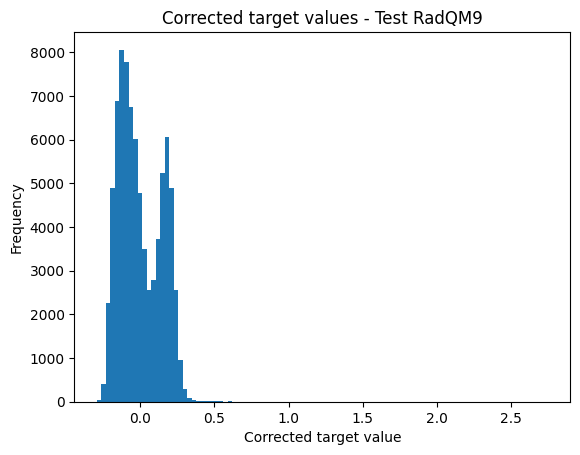

In [6]:
# plot histogram of corrected target values
import matplotlib.pyplot as plt

plt.hist(debug_list, bins=100)
plt.title("Corrected target values - Test RadQM9")
plt.xlabel("Corrected target value")
plt.ylabel("Frequency")
# plt.show()
# save figu
plt.savefig("test_corrected_target_hist_radqm9.png")

In [20]:

elems_present_qm9 = [1, 6, 7, 8, 9]
target_refs_qm9 = np.array([ -0.6043395,  -38.02757738, -54.68707091, -75.1415187,  -99.75095746])

#qm9_val = pd.read_pickle(loc_qm9_val)
#matrix = coeff_matrix_func(elems_present_qm9, qm9_val)
df_ret, debug_list = target_correction(matrix, target_refs_qm9, qm9_val)
df_ret.to_pickle("../../../data/radqm9/radqm_val_corrected.json")

Correcting targets


In [10]:
df_ret, debug_list = target_correction(matrix, target_refs_qm9, qm9_val)
df_ret.to_pickle("../../../data/radqm9/radqm_val_corrected.json")

(218232, 5)

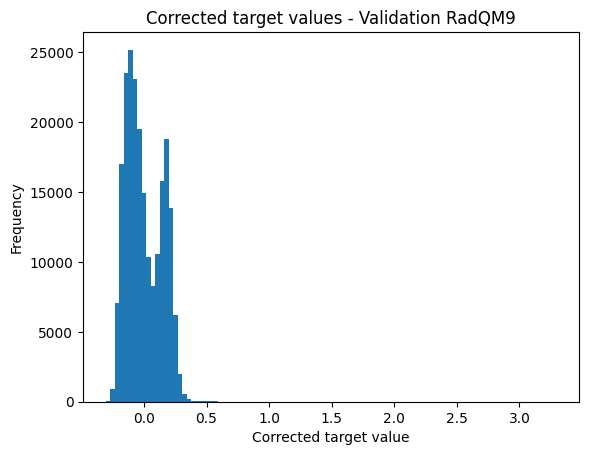

In [21]:
# plot histogram of corrected target values
import matplotlib.pyplot as plt

plt.hist(debug_list, bins=100)
plt.title("Corrected target values - Validation RadQM9")
plt.xlabel("Corrected target value")
plt.ylabel("Frequency")
# plt.show()
# save figu
plt.savefig("val_corrected_target_hist_radqm9.png")

In [ ]:
# Val 
# [1, 6, 7, 8, 9]
# [ -0.60436691 -38.02741257 -54.68735783 -75.14176493 -99.75075256]


# Test
#[1, 6, 7, 8, 9]
#[ -0.6045299  -38.02718335 -54.68838031 -75.14145179 -99.76828194]

# Train
#[1, 6, 7, 8, 9]
#[ -0.6043395  -38.02757738 -54.68707091 -75.1415187  -99.75095746]

~
